##### Sequence Model

$$
P(x_1, \ldots, x_T) = P(x_1) \prod_{t=2}^{T} P(x_t \mid x_{t-1}, \ldots, x_1)
$$

##### Markov Models and n-grams

If we can condition only on the $\tau$ previous time steps, i.e., $x_{t-1}, \ldots, x_{t-\tau}$, rather than the entire sequence history $x_{t-1}, \ldots, x_{1}$, we say that the sequence satisfies a Markov condition, i.e., that the future is conditionally independent of the past, given the recent history. When $\tau = 1$, we say that the data is characterized by a first-order Markov model, and when $\tau=k$, we say that the data is characterized by a k-order Markov model. For when the first-order Markov condition holds ($\tau = 1$) the factorization of our joint probability becomes a product of probabilities of each word given the previous word:

$$
P(x_1, \ldots, x_T) = P(x_1) \prod_{t=2}^{T} P(x_t \mid x_{t-1})
$$


In [159]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

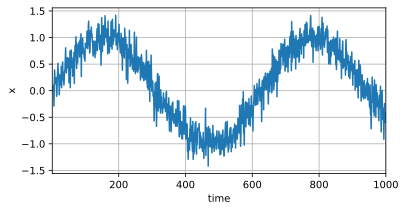

In [160]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [161]:
# Understanding the dimension parameter in torch.stack()

print("=== torch.stack() with different dimensions ===")

a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6]) 
c = torch.tensor([7, 8, 9])
d = torch.tensor([10, 11, 12])


tensors = [a, b, c, d]
print("torch.stack() input: List/tuple of tensors")
print(f"Input tensors:")
print(f"a = {a}")
print(f"b = {b}")  
print(f"c = {c}")
print(f"d = {d}")

print(f"\n--- torch.stack(tensors, 0) -> Stack along dimension 0 (rows) ---")
stack_0 = torch.stack(tensors, 0)
print(f"Result shape: {stack_0.shape}")
print(f"Result:\n{stack_0}")

print(f"\n--- torch.stack(tensors, 1) -> Stack along dimension 1 (columns) ---")
stack_1 = torch.stack(tensors, 1)  
print(f"Result shape: {stack_1.shape}")
print(f"Result:\n{stack_1}")

print(f"\n=== Why we use dimension 1 for features ===")
print("features[0] = [x[0], x[1], x[2], x[3], x[4], x[5]]  <- time steps 0-5")
print("features[1] = [x[1], x[2], x[3], x[4], x[5], x[6]]  <- time steps 1-6") 
print("features[2] = [x[2], x[3], x[4], x[5], x[6], x[7]]  <- time steps 2-7")
print("features[3] = [x[3], x[4], x[5], x[6], x[7], x[8]]  <- time steps 3-8")
print("")
print("stack(features, 1) makes each ROW a sliding window:")
print("Row 0: [x[0], x[1], x[2], x[3]]  <- features from time 0,1,2,3")
print("Row 1: [x[1], x[2], x[3], x[4]]  <- features from time 1,2,3,4")
print("Row 2: [x[2], x[3], x[4], x[5]]  <- features from time 2,3,4,5")
print("...")
print("This creates (samples × time_steps) shape = (996, 4)")

=== torch.stack() with different dimensions ===
torch.stack() input: List/tuple of tensors
Input tensors:
a = tensor([1, 2, 3])
b = tensor([4, 5, 6])
c = tensor([7, 8, 9])
d = tensor([10, 11, 12])

--- torch.stack(tensors, 0) -> Stack along dimension 0 (rows) ---
Result shape: torch.Size([4, 3])
Result:
tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12]])

--- torch.stack(tensors, 1) -> Stack along dimension 1 (columns) ---
Result shape: torch.Size([3, 4])
Result:
tensor([[ 1,  4,  7, 10],
        [ 2,  5,  8, 11],
        [ 3,  6,  9, 12]])

=== Why we use dimension 1 for features ===
features[0] = [x[0], x[1], x[2], x[3], x[4], x[5]]  <- time steps 0-5
features[1] = [x[1], x[2], x[3], x[4], x[5], x[6]]  <- time steps 1-6
features[2] = [x[2], x[3], x[4], x[5], x[6], x[7]]  <- time steps 2-7
features[3] = [x[3], x[4], x[5], x[6], x[7], x[8]]  <- time steps 3-8

stack(features, 1) makes each ROW a sliding window:
Row 0: [x[0], x[1], x[2], x[3]]  <- fe

In [162]:
# Simple & clear, but very efficient because of explicit loop

xx = torch.zeros(996, 4)
yy = torch.zeros(996, 1)

for i in range(996):
    xx[i] = data.x[i:i+4]
    yy[i] = data.x[i+4]

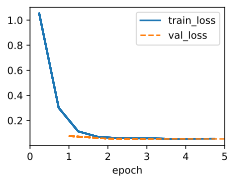

In [163]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

In [164]:
data.features.shape

torch.Size([996, 4])

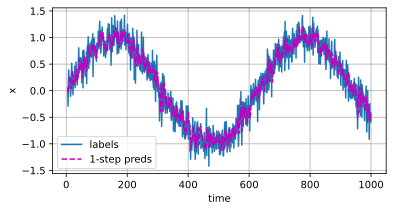

In [165]:
# To evaluate our model, we first check how well it performs at one-step-ahead prediction.

onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x', legend=['labels', '1-step preds'], figsize=(6, 3))

#### Why One-Step Predictions Aren't 100% Accurate (Even on Training Data)

This is a great question that highlights an important concept in sequence modeling!

In [166]:
print("🤔 Why aren't one-step predictions 100% accurate on training data?")
print()

print("📊 Key Reasons:")
print()

print("1️⃣ **The Data Has Inherent Noise**")
print("   Look at how we generated the data:")
print("   x = sin(0.01 * time) + torch.randn(T) * 0.2")
print("                        ^^^^^^^^^^^^^^^^^^^^ <- NOISE!")
print("   Even if we know the perfect pattern, we can't predict the random noise!")
print()

print("2️⃣ **Limited Model Capacity**")
print("   - We're using a simple LINEAR model: y = W @ x + b")
print("   - But the underlying pattern is sinusoidal (non-linear)")
print("   - Linear model can only approximate the sine wave, not capture it perfectly")
print()

print("3️⃣ **Finite History Window (τ=4)**")
print("   - Model only sees last 4 time steps to predict next value")
print("   - For perfect sine wave prediction, you'd need to know the exact phase")
print("   - 4 points might not always be enough to determine the precise next value")
print()

print("🔍 Let's examine the original sine wave data (from earlier):")
print("We'll need to go back to the Data class example to see the noise clearly")
print("But you can see in the plot that values aren't perfectly smooth - that's the noise!")
print()

print("📈 What the model learns:")
print("- It learns the overall sinusoidal trend")
print("- But it CANNOT predict the random noise component")
print("- So predictions will always have some error, even on training data")
print()

print("💡 This is actually GOOD!")
print("- Perfect memorization would be overfitting")
print("- The model learns the underlying pattern, not the noise")
print("- This makes it more likely to generalize to new data")

🤔 Why aren't one-step predictions 100% accurate on training data?

📊 Key Reasons:

1️⃣ **The Data Has Inherent Noise**
   Look at how we generated the data:
   x = sin(0.01 * time) + torch.randn(T) * 0.2
                        ^^^^^^^^^^^^^^^^^^^^ <- NOISE!
   Even if we know the perfect pattern, we can't predict the random noise!

2️⃣ **Limited Model Capacity**
   - We're using a simple LINEAR model: y = W @ x + b
   - But the underlying pattern is sinusoidal (non-linear)
   - Linear model can only approximate the sine wave, not capture it perfectly

3️⃣ **Finite History Window (τ=4)**
   - Model only sees last 4 time steps to predict next value
   - For perfect sine wave prediction, you'd need to know the exact phase
   - 4 points might not always be enough to determine the precise next value

🔍 Let's examine the original sine wave data (from earlier):
We'll need to go back to the Data class example to see the noise clearly
But you can see in the plot that values aren't perfectly sm

In [167]:
data.num_train

600

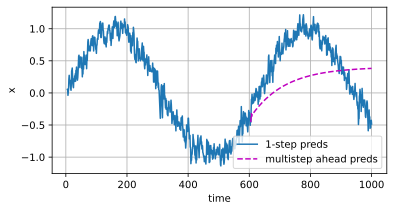

In [168]:
# multi-step prediction

multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep ahead preds'], figsize=(6, 3))

# It failed fail spectacularly

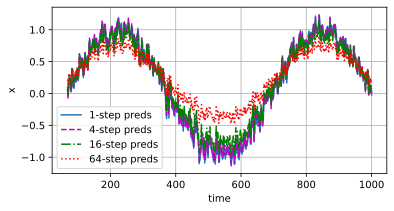

In [169]:
# Let’s take a closer look at the difficulties in k-step-ahead predictions by computing predictions on the entire sequence for k = 1,4,16,64.
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))


==================Converting Raw Text into Sequence Data===================

In [170]:
import collections
import random
import re
import torch
from d2l import torch as d2l

In [171]:
class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:100]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Traveller (for so it will be convenient to '

In [172]:
@d2l.add_to_class(TimeMachine)  #@save
def _preprocess(self, text):
    # For simplicity, we ignore punctuation and capitalization
    # [^...] = Negation; + = One or more consecutive occurrences
    # '[^A-Za-z]+' = 'one or more characters that are NOT letters'
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:100]

'the time machine by h g wells i the time traveller for so it will be convenient to speak of him was '

In [173]:
@d2l.add_to_class(TimeMachine)  #@save
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [174]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [175]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [176]:
@d2l.add_to_class(TimeMachine)  #@save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

In [177]:
vocab.idx_to_token

[' ',
 '<unk>',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [178]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

# ten most frequent words are not all that descriptive: stop words

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

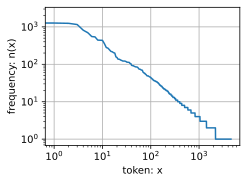

In [179]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log')

# word frequency decays quickly. The 10-th most frequent word is less than 1/5 as common as the most popular. Word frequency tends to follow a
# power law distribution (specifically the Zipfian) as we go down the ranks.

In [180]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]
# Out of the ten most frequent word pairs, nine are composed of both stop words and only one is relevant to the actual book — "the time"

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [181]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

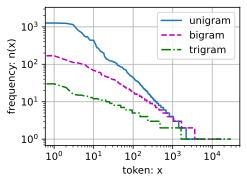

In [182]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [183]:
# Text is among the most common forms of sequence data encountered in deep learning. 
# Common choices for what constitutes a token are characters, words, and word pieces. To preprocess text, we usually 
# (i) split text into tokens; 
# (ii) build a vocabulary to map token strings to numerical indices;
# (iii) convert text data into token indices for models to manipulate. 
# In practice, the frequency of words tends to follow Zipf’s law. This is true not just for individual words (unigrams), but also for n-grams.

======================Language Models========================

In [184]:
import torch
from d2l import torch as d2l

In [185]:
@d2l.add_to_class(d2l.TimeMachine)  #@save
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1] for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

In [186]:
@d2l.add_to_class(d2l.TimeMachine)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

In [187]:
data = d2l.TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[20, 26,  4,  9, 16, 13, 16,  8, 10, 20],
        [10, 15,  6,  0,  3, 26,  0,  9,  0,  8]]) 
Y: tensor([[26,  4,  9, 16, 13, 16,  8, 10, 20, 21],
        [15,  6,  0,  3, 26,  0,  9,  0,  8,  0]])


=================== Recurrent Neural Networks=====================

![RNN](./Images/RNN_1.png)

1. **Hidden state**
$
\mathbf{H}_t = \phi_l\left( \mathbf{H}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh} + \mathbf{b}_h \right)
$

2. **Output:**
$
\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q
$

In [188]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [189]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    # Shape of inputs: (num_steps, batch_size, num_inputs)
    # num_inputs: means input feature dimension, can means 27 if using char one-hot embedding, or embedding_dimension if using word embeddings
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  
        # Shape of X: (batch_size, num_inputs)
        # state: previous loops' output state
        state = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

In [190]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [191]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [192]:
X.shape # (100, 2, 16)

for y in X:
    print(y.shape) # (2, 16)

torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])


In [199]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(torch.randn(self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

@d2l.add_to_class(RNNLMScratch)  #@save
def one_hot(self, X):
    # Shape of X: (batch_size, num_steps)
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

@d2l.add_to_class(RNNLMScratch)  #@save
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    # outputs: list of (batch_size, vocab_size), length=num_steps
    # return shape: (batch_size, num_steps, vocab_size)
    return torch.stack(outputs, 1)
@d2l.add_to_class(RNNLMScratch)  #@save
def forward(self, X, state=None):
    # shape of X: (batch_size, num_steps)
    # shape of embs: (num_steps, batch_size, vocab_size)
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    # return shape: (batch_size, num_steps, vocab_size)
    return self.output_layer(rnn_outputs)

In [200]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [209]:
# Create RNN with correct input size (vocab_size for one-hot encoding)
rnn = RNNScratch(len(data.vocab), num_hiddens)
model = RNNLMScratch(rnn, len(data.vocab))
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, len(data.vocab)))

In [210]:
# gradient clipping

@d2l.add_to_class(d2l.Trainer)  #@save
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    # norm is total squared gradient norm 
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

#### Understanding Gradient Clipping

Gradient clipping is a crucial technique for training RNNs that prevents the **exploding gradient problem**.

In [218]:
print("🔧 What Gradient Clipping Does:")
print()

print("📊 Step-by-Step Breakdown:")
print()

print("1️⃣ **Collect All Trainable Parameters**")
print("   params = [p for p in model.parameters() if p.requires_grad]")
print("   → Gets all weight matrices and biases that need gradient updates")
print()

print("2️⃣ **Calculate Total Gradient Norm**")
print("   norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))")
print("   → Computes L2 norm of ALL gradients combined")
print("   → This is like measuring the 'magnitude' of the total gradient vector")
print()

print("3️⃣ **Check if Clipping is Needed**")
print("   if norm > grad_clip_val:")
print("   → Only clip if gradients are too large (exceed threshold)")
print()

print("4️⃣ **Scale Down All Gradients Proportionally**")
print("   param.grad[:] *= grad_clip_val / norm")
print("   → Multiply each gradient by (threshold / current_norm)")
print("   → This keeps the gradient direction but reduces magnitude")
print()

print("🎯 **The Key Insight:**")
print("- If norm = 10 and grad_clip_val = 1:")
print("  → Scale factor = 1/10 = 0.1")
print("  → All gradients become 10× smaller")
print("- If norm = 0.5 and grad_clip_val = 1:")
print("  → No clipping (norm < threshold)")
print("  → Gradients remain unchanged")
print()

print("✅ **Result:**")
print("- Large gradients → Scaled down to reasonable size")
print("- Small gradients → Left unchanged")
print("- Prevents exploding gradients while preserving training direction!")

🔧 What Gradient Clipping Does:

📊 Step-by-Step Breakdown:

1️⃣ **Collect All Trainable Parameters**
   params = [p for p in model.parameters() if p.requires_grad]
   → Gets all weight matrices and biases that need gradient updates

2️⃣ **Calculate Total Gradient Norm**
   norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
   → Computes L2 norm of ALL gradients combined
   → This is like measuring the 'magnitude' of the total gradient vector

3️⃣ **Check if Clipping is Needed**
   if norm > grad_clip_val:
   → Only clip if gradients are too large (exceed threshold)

4️⃣ **Scale Down All Gradients Proportionally**
   param.grad[:] *= grad_clip_val / norm
   → Multiply each gradient by (threshold / current_norm)
   → This keeps the gradient direction but reduces magnitude

🎯 **The Key Insight:**
- If norm = 10 and grad_clip_val = 1:
  → Scale factor = 1/10 = 0.1
  → All gradients become 10× smaller
- If norm = 0.5 and grad_clip_val = 1:
  → No clipping (norm < threshold)
  →

In [219]:
print("🚨 Why RNNs Need Gradient Clipping:")
print()

print("🔄 **The Exploding Gradient Problem in RNNs:**")
print()

print("1️⃣ **Chain Rule Through Time**")
print("   - RNNs process sequences step by step")
print("   - Gradients flow backward through ALL time steps")
print("   - Each step multiplies gradients by weight matrices")
print()

print("2️⃣ **Gradient Explosion**")
print("   - If weights > 1: gradients grow exponentially")
print("   - Long sequences = many multiplications")
print("   - Result: gradients can become HUGE (10^10 or more!)")
print()

print("3️⃣ **What Happens Without Clipping:**")
print("   - Massive gradient updates")
print("   - Weights jump to extreme values")
print("   - Loss explodes to NaN")
print("   - Training completely fails")
print()

print("4️⃣ **What Clipping Provides:**")
print("   - Caps maximum gradient magnitude")
print("   - Keeps weight updates reasonable")
print("   - Allows stable training of long sequences")
print("   - Preserves learning direction")
print()

print("📈 **Mathematical Intuition:**")
print("Without clipping: gradient = 1000 → weight += lr * 1000 (too big!)")
print("With clipping:    gradient = 1    → weight += lr * 1    (just right!)")
print()

print("💡 **Best Practice:**")
print("- Common clip values: 1.0, 0.5, or 5.0")
print("- Monitor gradient norms during training")
print("- Essential for any RNN/LSTM/GRU training!")

🚨 Why RNNs Need Gradient Clipping:

🔄 **The Exploding Gradient Problem in RNNs:**

1️⃣ **Chain Rule Through Time**
   - RNNs process sequences step by step
   - Gradients flow backward through ALL time steps
   - Each step multiplies gradients by weight matrices

2️⃣ **Gradient Explosion**
   - If weights > 1: gradients grow exponentially
   - Long sequences = many multiplications
   - Result: gradients can become HUGE (10^10 or more!)

3️⃣ **What Happens Without Clipping:**
   - Massive gradient updates
   - Weights jump to extreme values
   - Loss explodes to NaN
   - Training completely fails

4️⃣ **What Clipping Provides:**
   - Caps maximum gradient magnitude
   - Keeps weight updates reasonable
   - Allows stable training of long sequences
   - Preserves learning direction

📈 **Mathematical Intuition:**
Without clipping: gradient = 1000 → weight += lr * 1000 (too big!)
With clipping:    gradient = 1    → weight += lr * 1    (just right!)

💡 **Best Practice:**
- Common clip values

In [220]:
# Concrete example of gradient clipping in action
print("🧮 Concrete Example:")
print()

# Simulate some gradients
import torch

# Create fake gradients for demonstration
grad1 = torch.tensor([3.0, 4.0])  # Some parameter gradients
grad2 = torch.tensor([5.0])       # Another parameter gradient
grad3 = torch.tensor([1.0, 2.0])  # Third parameter gradient

print("📋 Before Clipping:")
print(f"Parameter 1 gradients: {grad1}")
print(f"Parameter 2 gradients: {grad2}")
print(f"Parameter 3 gradients: {grad3}")
print()

# Calculate total norm (like in the clip_gradients function)
total_norm = torch.sqrt(
    torch.sum(grad1 ** 2) + 
    torch.sum(grad2 ** 2) + 
    torch.sum(grad3 ** 2)
)
print(f"📏 Total gradient norm: {total_norm:.4f}")

# Apply clipping with threshold = 1.0
grad_clip_val = 1.0
print(f"🎯 Clipping threshold: {grad_clip_val}")
print()

if total_norm > grad_clip_val:
    scale_factor = grad_clip_val / total_norm
    print(f"⚠️  Gradients too large! Scaling by: {scale_factor:.4f}")
    
    # Apply clipping
    grad1_clipped = grad1 * scale_factor
    grad2_clipped = grad2 * scale_factor
    grad3_clipped = grad3 * scale_factor
    
    print()
    print("✂️  After Clipping:")
    print(f"Parameter 1 gradients: {grad1_clipped}")
    print(f"Parameter 2 gradients: {grad2_clipped}")
    print(f"Parameter 3 gradients: {grad3_clipped}")
    
    # Verify new norm
    new_norm = torch.sqrt(
        torch.sum(grad1_clipped ** 2) + 
        torch.sum(grad2_clipped ** 2) + 
        torch.sum(grad3_clipped ** 2)
    )
    print(f"📏 New gradient norm: {new_norm:.4f}")
else:
    print("✅ Gradients are fine, no clipping needed!")
    
print()
print("🎓 Key Takeaway:")
print("- Original norm was too large (> 1.0)")
print("- All gradients scaled down proportionally")
print("- New norm exactly equals the threshold")
print("- Gradient directions preserved, only magnitude reduced!")

🧮 Concrete Example:

📋 Before Clipping:
Parameter 1 gradients: tensor([3., 4.])
Parameter 2 gradients: tensor([5.])
Parameter 3 gradients: tensor([1., 2.])

📏 Total gradient norm: 7.4162
🎯 Clipping threshold: 1.0

⚠️  Gradients too large! Scaling by: 0.1348

✂️  After Clipping:
Parameter 1 gradients: tensor([0.4045, 0.5394])
Parameter 2 gradients: tensor([0.6742])
Parameter 3 gradients: tensor([0.1348, 0.2697])
📏 New gradient norm: 1.0000

🎓 Key Takeaway:
- Original norm was too large (> 1.0)
- All gradients scaled down proportionally
- New norm exactly equals the threshold
- Gradient directions preserved, only magnitude reduced!


In [211]:
# During "warm-up" phase (processing the prefix "it has"):

# Each character updates the hidden state
# Hidden state accumulates information from ALL previous characters
# By the end, state contains compressed context of the entire prefix
# During prediction phase:

# Uses the accumulated state (containing entire context)
# Plus current character → predicts next character
# Updates state with new information → predicts next character
# And so on...

@d2l.add_to_class(RNNLMScratch)  #@save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        # get last character from output as input
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [212]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it hasduhijsssssssssssssss'

===========================Concise Implementation of Recurrent Neural Networks===========================

In [213]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [214]:
class RNN(d2l.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

In [215]:
class RNNLM(d2l.RNNLMScratch):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        # print("- PyTorch's nn.RNN uses time-first format: (time, batch, features)")
        # print("- But our loss functions expect batch-first: (batch, time, features)")
        # print("- swapaxes(0,1) converts time-first → batch-first")
        # print("- This ensures compatibility with the rest of our code!")

        return self.linear(hiddens).swapaxes(0, 1)

In [216]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it hasgjpg<unk>zspgjzspgjzspgj'

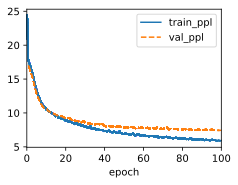

In [217]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

================Backpropagation Through Time===========================

In [ ]:
### TODO read